In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))
import random
import spacy
import pickle
import pandas as pd
from nltk import Tree
from spacy import displacy
from spacy.gold import GoldParse
from IPython.display import Image
# !{sys.executable} -m pip install -r ../requirements.txt

In [2]:
nlp_sm = spacy.load("en_core_web_sm")
ORG_ENTITY_TYPE = ["ORG", "PERSON", "PRODUCT"]

#### Intro to Entity Recognition from text

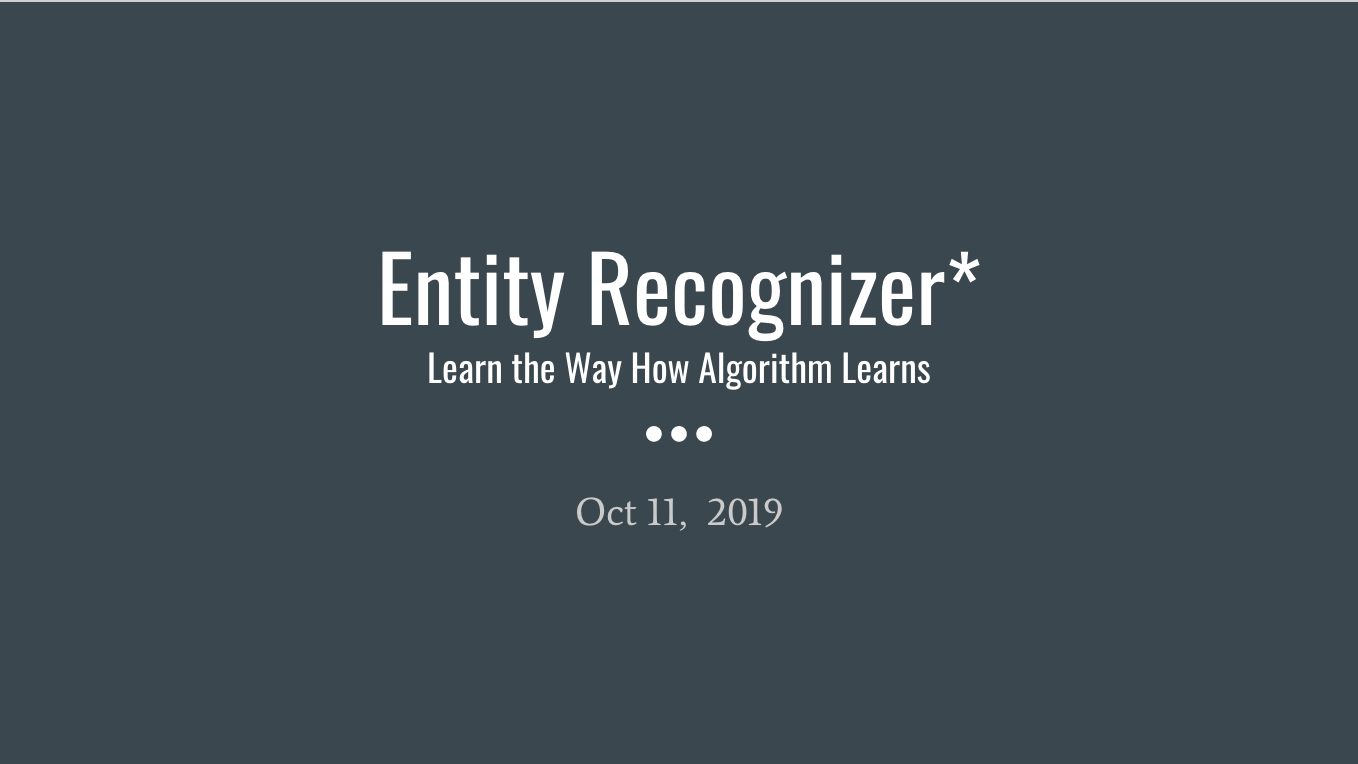

In [23]:
Image(filename=f"data/front_page.png", width=1000, height=1000)

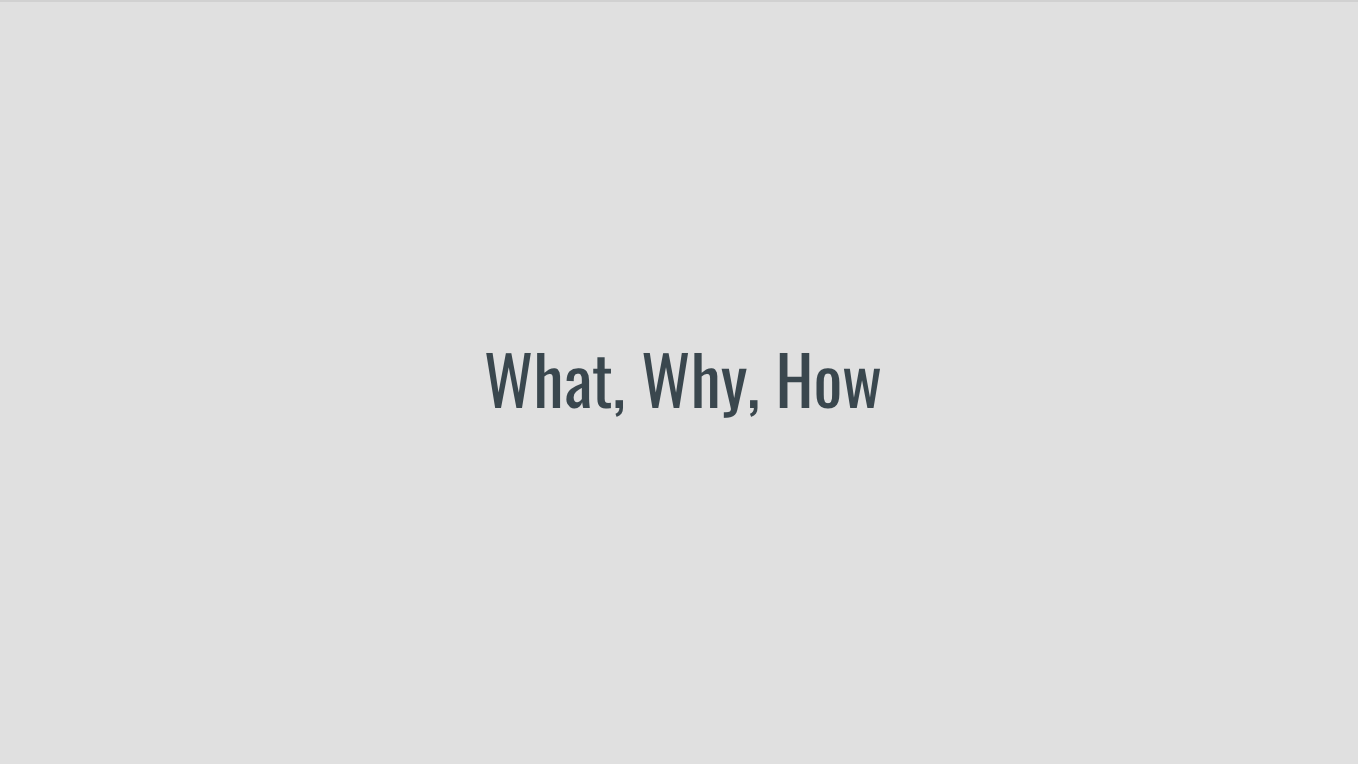

In [24]:
Image(filename=f"data/www.png", width=1000, height=1000)

#### Start Spacy NLP pipeline with default English Model

Spacy'S NER MODEL: Incremental parsing with Bloom embeddings & residual CNNs 

_Highlights_: 
    1. No fixed vocab, chunk is represented as dense embedding (norm, prefix, suffix, shape), therefore, tolerate for unseen words (kind of).
    2. Use techiques called Transition sequence of tokenized chunk with Stack-LSTM model

In [3]:
def nltk_tree(t):
    return Tree(t[0], [c if isinstance(c, str) else nltk_tree(c) for c in t[1:]])
def to_nltk_tree(node):
    if node.n_lefts + node.n_rights > 0:
        return Tree(node.orth_, [to_nltk_tree(child) for child in node.children])
    else:
        return node.orth_

In [4]:
def display_tagged_entity_in_sent(doc, w_pprint=False, w_vector=True):
    "Visualize entity tagged given parsed tree (doc)"
    displacy.render(doc, style='ent', jupyter = True)
    if w_pprint:
        [to_nltk_tree(sent.root).pretty_print() for sent in doc.sents]
    doc_entity = displacy.parse_ents(doc)
    if w_vector:
        print("Extracted named entity from sentence -> position range -> entity vector (trim5)")
        for entity in doc.ents:
            if entity.label_ in ORG_ENTITY_TYPE:
                print("   ", entity, "->", (entity.start, entity.end), "->", entity.vector[0:5])

In [5]:
demo_sent0 = u"Uber investor Lead Edge Capital closes US$ 520 million fund."
demo_sent1 = u"Out of all of Apple’ s devices the 3 billion app downloads come up to around 19% of the total amount of downloads that iOS users are downloading onto their Apple products."
demo_sent2 = u"For instance , Apple stock (AAPL) reported that its ` ` services '' segment -- which includes iTunes , Apple Pay and other services -- is catching up to Macs at a 10% - plus share of total revenue."
demo_sent3 = u"Albeit , Alibaba (BABA) is considered the Walmart/Amazon of China, seeing a mind - boggling $ 112 billion of gross merchandise volume on its Chinese platforms during its calendar third quarter."
demo_sent4 = u"In Q4 alone , Bank of America processed over 23 million transactions , totaling nearly $ 7 billion , up 91 percent from the prior year ."
demo_sent5 = u"CI Capital Partners , a North American private investment firm , announced that it has acquired Galls , LLC , a $ 163 million revenue , full-service marketer and distributor of public safety , first responder and private security products , from ARAMARK Corporation."

In [6]:
test_sent1= u"Samsung Pay is off to a solid start with an estimated 1 million users in Korea and acceptable uptake in the US."
test_sent2 = u"The company claims that Instagram has 250 million daily active users , and more than 50 % of businesses on the platform have created Instagram Stories in the past month."
test_sent3 = u"On Tuesday , shares of parent company Snap dipped slightly following the news that Instagram Stories now tops 250 million daily active users , easily outpacing the 166 million daily users that Snapchat reported last month."
test_sent4 = u"In comparison to Instagram Stories , Facebook Stories has just about 150 million daily active users as of May."
test_sent5 = u"The NFL streams , powered by Amazon Web Services , will be available to more than 100 million Amazon Prime members worldwide in more than 200 countries and territories on the Prime Video app for TVs , game consoles , and connected devices , which includes Amazon Fire TV , mobile devices and online."
test_sent6 = u"Links to its rival Alibaba have long been inaccessible on WeChat , which had more than 1 billion monthly active users as of September."
test_sent7 = u"According to Alibaba 's latest quarterly financial report , Alipay has over 700 million users in China and 70 % of them have used three or more services provided by Ant Financial."
test_data = [test_sent1, test_sent2, test_sent3, test_sent4, test_sent5, test_sent6, test_sent7]

##### Display Named Entities in Sentence

In [7]:
demo_doc0 = nlp_sm(demo_sent1)
display_tagged_entity_in_sent(demo_doc0, True, False)

      devices    
         |        
        Out      
         |        
         of      
         |        
        all      
         |        
         of      
         |        
         ’       
   ______|_____   
Apple          s 

                                     come                                                               
  ____________________________________|______________________________________                            
 |   |          |                          to                                |                          
 |   |          |                          |                                 |                           
 |   |          |                          %                                 |                          
 |   |          |                __________|____                             |                           
 |   |          |               |               of                      downloading                     
 |   |          |    

###### Entity occurs multiple times in the sentence will have unique vector representation given the context
Spacy’s NER model is a shallow feedforward neural network (CNN) with a single hidden layer and inputs are processed through feature engineering.
Input is a stack of weighted bloom embedding layers merge neighbouring (window size 1-3) features together. 

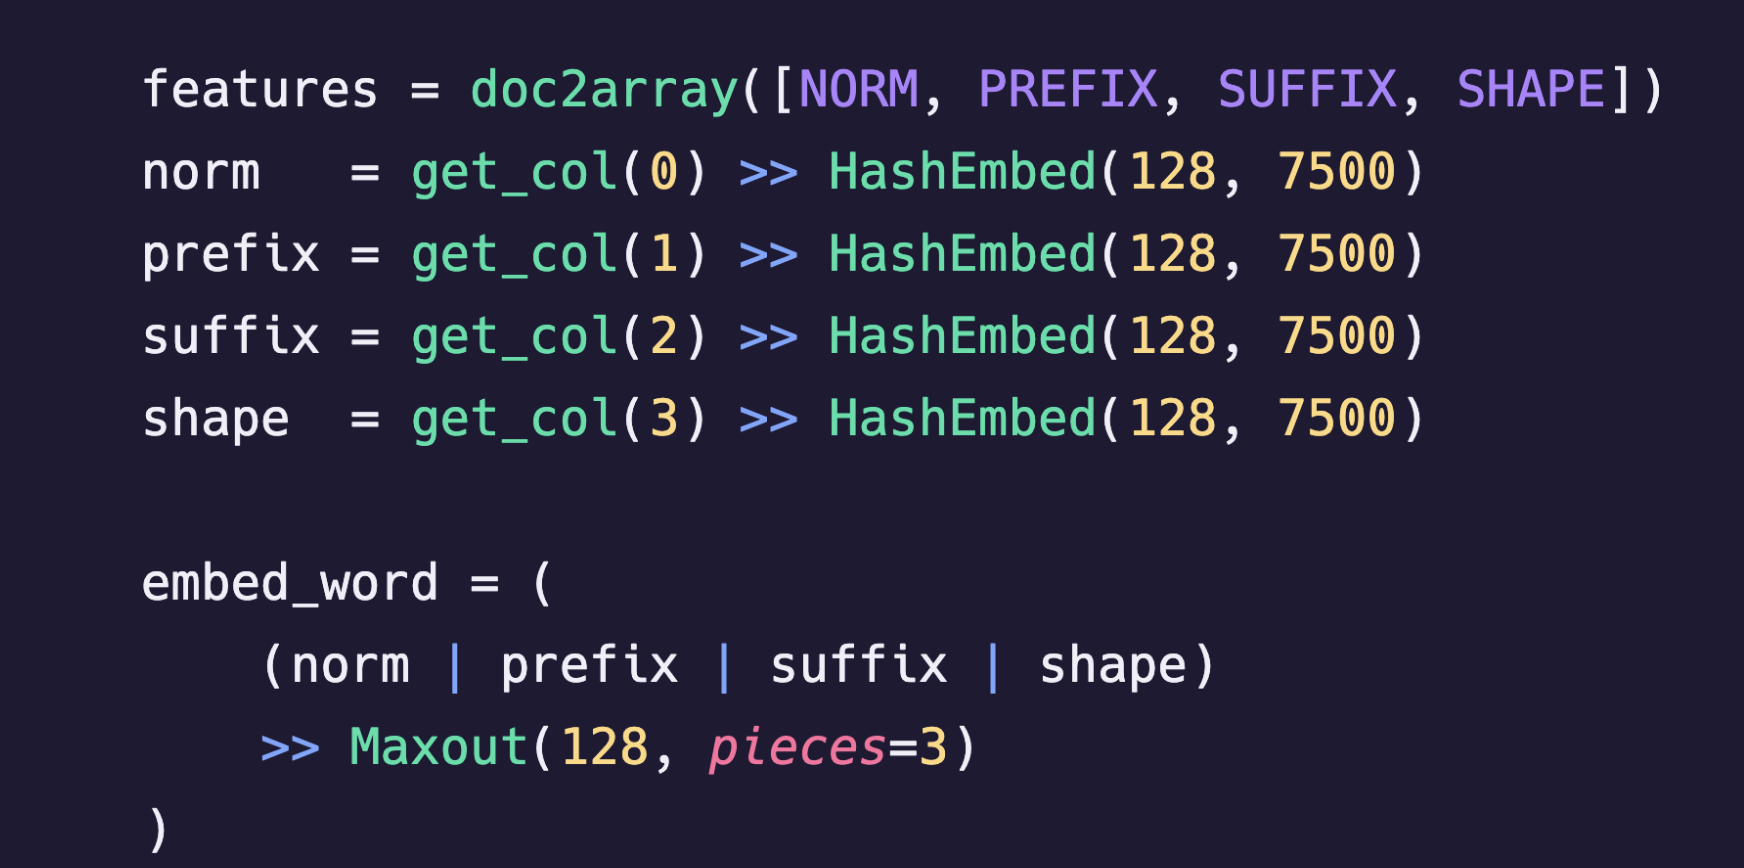

In [25]:
Image(filename=f"data/spacy_tensor.png", width=1000, height=1000)

In [8]:
demo_doc1 = nlp_sm(demo_sent1)
display_tagged_entity_in_sent(demo_doc1, False)

Extracted named entity from sentence -> position range -> entity vector (trim5)
    Apple -> (4, 5) -> [ 5.626216   -1.4398216  -2.2867117  -0.83804846 -1.3257145 ]
    Apple -> (32, 33) -> [ 5.140746   -0.6443368  -1.8986521  -1.7327129   0.66882575]


###### Observe different variant of entity names wasn't recongized or with incorrect entity type

In [9]:
demo_doc4 = nlp_sm(demo_sent4)
display_tagged_entity_in_sent(demo_doc4, False)

Extracted named entity from sentence -> position range -> entity vector (trim5)
    Bank of America -> (4, 7) -> [ 3.5044975  -2.4784377  -2.3028164  -3.614516   -0.54510003]


##### Compare Entity Recognization model performance

In [266]:
Image(url= "https://mindcraft.ai/wp-content/uploads/2019/08/model-performs.png")

###### NER model from CoreNLP
StanfordNLP is a collection of pre-trained state-of-the-art models. And it uses a probabilistic model called a Conditional Random Field (CRF).

`wget http://nlp.stanford.edu/software/stanford-corenlp-full-2018-02-27.zip
unzip stanford-corenlp-full-2018-02-27.zip
cd stanford-corenlp-full-2018-02-27`

Download and Start the server/stanford-corenlp-full-2018-02-27 directory

`java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer \
-preload tokenize,ssplit,pos,lemma,ner,parse,depparse \
-status_port 9090 -port 9090 -timeout 15000 & `

In [10]:
def extract_entity_with_ner_tags(tagged_tokens):
    "Filter for entities from NER predictor."
    entities = []
    entity = []
    for word in tagged_tokens:
        if word[1] != 'O':
            entity.append(word)
        else:
            if entity:
                entities.append(entity)
            entity = []
    return entities

In [11]:
from nltk.parse import CoreNLPParser
ner_tagger = CoreNLPParser(url='http://localhost:9090', tagtype='ner')

In [12]:
demo_tokens4 = ner_tagger.tag([tok.text for tok in demo_doc4])
extract_entity_with_ner_tags(demo_tokens4)

[[('Bank', 'ORGANIZATION'),
  ('of', 'ORGANIZATION'),
  ('America', 'ORGANIZATION')],
 [('23', 'NUMBER'), ('million', 'NUMBER')],
 [('$', 'MONEY'), ('7', 'MONEY'), ('billion', 'MONEY')],
 [('91', 'PERCENT'), ('percent', 'PERCENT')],
 [('the', 'DATE'), ('prior', 'DATE'), ('year', 'DATE')]]

###### NER model from Allenlp
Similar to LSTM, the Gated Recurrent Unit (GRU) Network used by NER model embeds words at the character level and another GRU to encode phrases from words embedding using Glove.

In [27]:
Image(url="https://miro.medium.com/max/2048/1*7nJBjWOMAhT21G1xkagG3Q.png", width=800, height=800)

In [13]:
# !pip install allennlp==0.8.5
from allennlp.predictors import Predictor
from allennlp.models.archival import load_archive
try:
    MODEL = load_archive("/root/.allennlp/cache/fine-grained-ner-model-elmo-2018.12.21.tar.gz")
except Exception:
    AWS_MODEL_FOLDER = "https://s3-us-west-2.amazonaws.com/allennlp/models/"
    MODEL = load_archive(AWS_MODEL_FOLDER + "fine-grained-ner-model-elmo-2018.12.21.tar.gz")
ner_predictor = Predictor.from_archive(MODEL)

/Users/shisi/anaconda3/envs/bert_experiment/lib/python3.7/site-packages/allennlp/data/token_indexers/token_characters_indexer.py:56: UserWarning: You are using the default value (0) of `min_padding_length`, which can cause some subtle bugs (more info see https://github.com/allenai/allennlp/issues/1954). Strongly recommend to set a value, usually the maximum size of the convolutional layer size when using CnnEncoder.
  UserWarning)


In [14]:
result = ner_predictor.predict(sentence=demo_sent5)
demo_tokens5 = (zip(result['words'], result['tags']))
extract_entity_with_ner_tags(demo_tokens5)

[[('CI', 'B-ORG'), ('Capital', 'I-ORG'), ('Partners', 'L-ORG')],
 [('North', 'B-NORP'), ('American', 'L-NORP')],
 [('Galls', 'B-ORG'), (',', 'I-ORG'), ('LLC', 'L-ORG')],
 [('$', 'B-MONEY'), ('163', 'I-MONEY'), ('million', 'L-MONEY')],
 [('first', 'U-ORDINAL')],
 [('ARAMARK', 'B-ORG'), ('Corporation', 'L-ORG')]]

Encourage you to try other NER models on your own:
    1. GATE API: https://cloud.gate.ac.uk/shopfront/displayItem/annie-named-entity-recognizer?fromApi=1
    2. Flair (bi-LSTM on top of a word embedding layer)
    3. DeepPavlov(Hybrid Bi-LSTM-CRF model)
The last two you can do pip install and load ner model pretrained on different dataset

#### Improve Entity Recognized model with Pattern Matching
The default NER models, both Spacy and CoreNLP is not Perfect:
it does not detect all Named Entities or misclassified Entity Type. Now, we want to go further, by adding pattern matching or training a more complete (or dataset specific) model.

In [15]:
from extractor.entity_extractor import EntityExtractor
"Prepare to add additional entities to match against."

extractor = EntityExtractor(nlp_sm)
extractor.set_entity_rules([{"IS_DIGIT": True}, {"TAG": "CD"}], "SHORT_MONEY")
extractor.set_entity_rules([{"IS_DIGIT": True}, {"TAG": "CD"}, {"TAG": "NNS"}], "PLURAL_NOUN")
extractor.set_entity_patterns(['Q4'], 'DATE')


### entities from default NER model
print("spaCy NER:", [(ent, ent.label_) for ent in demo_doc4.ents])
print("--------")
entities = extractor.extract(demo_sent4)
print("Demo nlp_processing entity extractor:", [(ent, ent.label_) for ent in entities])

spaCy NER: [(Bank of America, 'ORG'), (over 23 million, 'CARDINAL'), (nearly $ 7 billion, 'MONEY'), (91 percent, 'PERCENT'), (the prior year, 'DATE')]
--------
Demo nlp_processing entity extractor: [(Q4, 'DATE'), (Bank of America, 'ORG'), (23 million transactions, 'PLURAL_NOUN'), (7 billion, 'SHORT_MONEY'), (91 percent, 'PERCENT'), (the prior year, 'DATE')]


#### Retrain NER with updated entity info

##### Prepare training data to update NER model with a small opearating metric sentences
SpaCy requires the training data to be in the the following format: 
[(sent_string, {'entities': [(start_pos, end_pos, Label] })]

In [53]:
df_tuple = pd.read_csv(f"data/train_tuple_w_pos.csv")
df_sents = df_tuple.groupby(['id_news', 'sentnum']).entity.apply(list).reset_index()
df_sents.columms = ['id_news', 'sentnum', 'entities']
print(df_tuple.shape, df_sents.shape)
df_sents.head(3)

,id_news,sentnum,entity
0,39000,4,"[AirG, social network]"
1,114149,2,[Twitter]
2,135380,5,"[Netflix, Netflix, Netflix, HBO, HBO, HBO]"


In [80]:
# prepre training data
def recognize_org_from_doc(entity_recognier, doc, sent_orgs):
    doc_ents = []
    entity_recognier.add_entities_to_matcher(sent_orgs)
    entity_recognier.match_assigned_entities(doc)
    for ent in doc.ents:
        doc_ents.append((ent.start, ent.end, ent.label_))
    if doc_ents:
        return (doc.text,  {"entities": doc_ents})
    return None

def prepare_train_data(df):
    train_data = []
    for idx, row in df.iterrows():
        entity_recognier = EntityRecognizer(nlp_sm)
        sent_info = prepare_sent_info(row['id_news'], row['sentnum'])
        sent_orgs = {nnp.phrase_surface for nnp in sent_info.sent_org_nnps}
        sent_orgs.update(row['entity'])
        sent_orgs = {org for org in sent_orgs if is_valid_entity_name(org) and org not in SOURCE_REPORTER}
        if sent_orgs:
            doc = nlp_sm(sent_info.sent_string)
            sent_ent_pos = recognize_org_from_doc(entity_recognier, doc, sent_orgs)
            if sent_ent_pos:
                train_data.append(sent_ent_pos)
    return train_data


def save_into_pickle(file_name, data):
    fwrite = open(file_name, "wb")
    pickle.dump(data, fwrite)

In [ ]:
ner2train = prepare_train_data(df_sents)
save_into_pickle(f"data/prepared_ner_train_data.pkl", train_data)

In [264]:
# Can potentially build a recognizer for NP and NNPs or update the parser
# for nnp in sent_info.sent_org_nnps:
#     print(nnp.phrase_surface, nnp.phrase_start, nnp.phrase_end)
#     print(phrase_locator.search_chunk_doc_position(nnp))
    
# for np_span in sentence_parser.tag_noun_chunks(demo_doc4, sent_info):
#     print(np_span, np_span.start, np_span.end)

##### Update NER  model with extra training data
Because we start with NER model of pretrained Spacy model, to train and update the model, we have to disable all other pipeline components.

So, only the entity recognizer gets trained.

In [96]:
def save_trained_ner_model(nlp, fname_ner_model):
    output_dir = Path(fname_ner_model)
    if not output_dir.exists():
        output_dir.mkdir()
    nlp.to_disk(output_dir)
    print("Saved model to", output_dir)
    

In [249]:
def update_ner_model(train_data, fname_output, niter=10):
    nlp = spacy.load('en_core_web_sm', entity=False, parser=False)
    ner = nlp.get_pipe('ner')
    optimizer = nlp.entity.create_optimizer()

    for itn in range(niter):
        losses = {}
        random.shuffle(train_data)
        for raw_text, entity_offsets in train_data:
            doc = nlp.make_doc(raw_text)
            gold = GoldParse(doc, entities=entity_offsets['entities'])
            nlp.tagger(doc)
            ner.update(doc, gold, drop=0.2, losses=losses)
    save_trained_ner_model(nlp, fname_ner_model)

In [250]:
fname_ner_model = f"data/retrained_ner.model"
# update ner model with our own small entity set (153)
update_ner_model(train_data, fname_ner_model)

Saved model to data/retrained_ner.model
Loading from data/retrained_ner.model


##### Test saved model performance on unseen opearating metric sentences

In [259]:
print("Loading from", fname_ner_model)
nlp2 = spacy.load(fname_ner_model)
for test_sent in test_data:
    test_doc = nlp2(test_sent)
    display_tagged_entity_in_sent(test_doc, False, False)
    print("------------------------------------------------------------------")

------------------------------------------------------------------


------------------------------------------------------------------


------------------------------------------------------------------


------------------------------------------------------------------


------------------------------------------------------------------


------------------------------------------------------------------


------------------------------------------------------------------


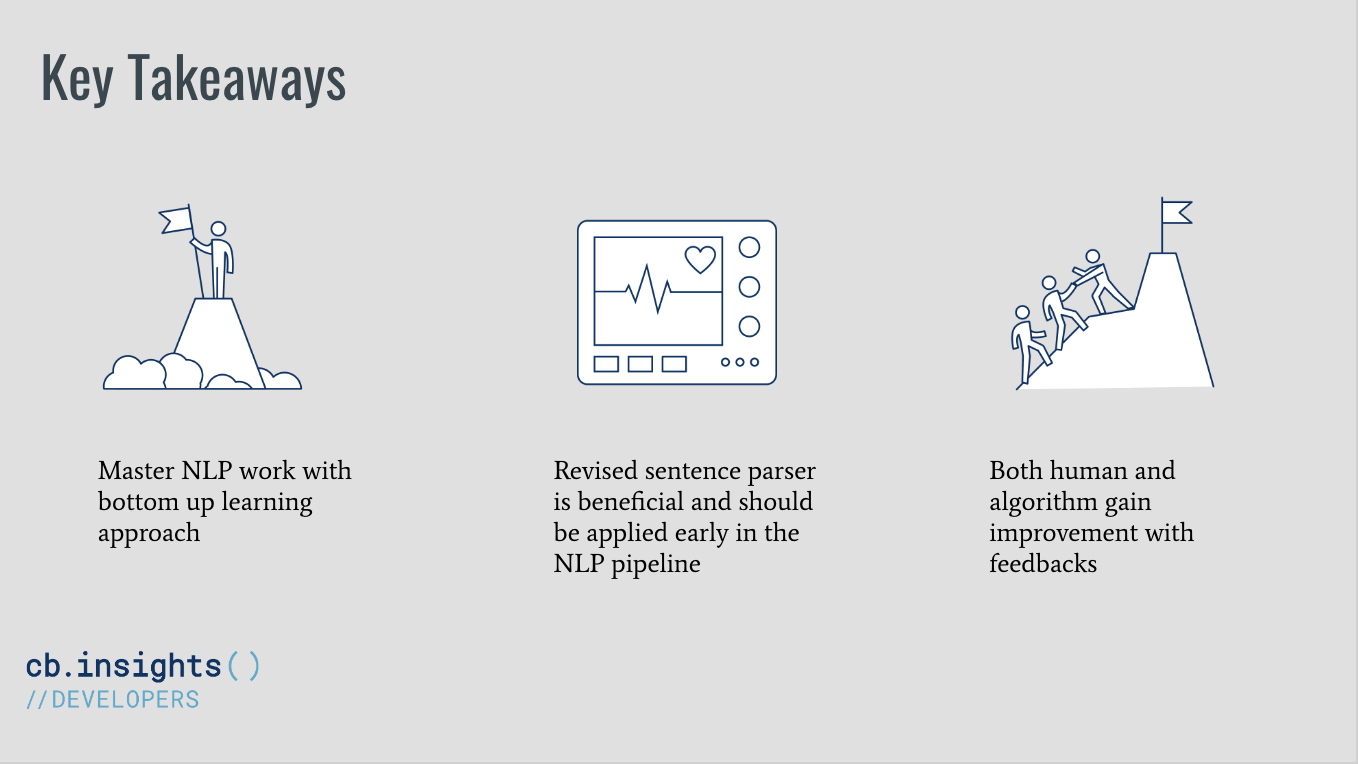

In [33]:
Image(filename=f"data/takeways.png", width=1000, height=1000)

#### Q&A Session and Export Jupyter

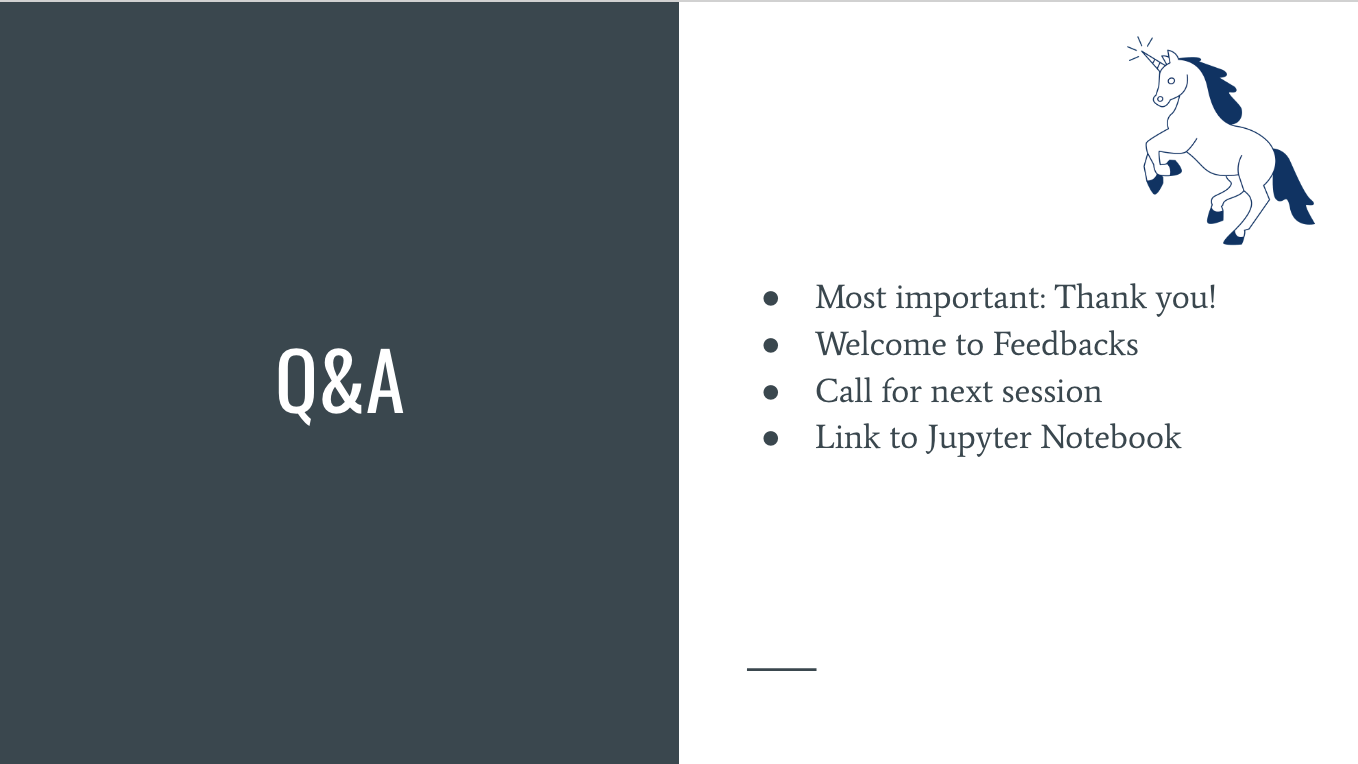

In [41]:
Image(filename=f"data/ending_page.png", width=600, height=600)

In [17]:
# !jupyter nbconvert Introduction to Named Entity Extraction.ipynb --to html --output Introduction to Named Entity Extraction.html